# Imports

In [1]:
import os
import sys
import pandas as pd
import numpy as np 
import requests

from io import BytesIO
from glob import glob
from PIL import Image, ImageColor
import colorsys

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Load Image

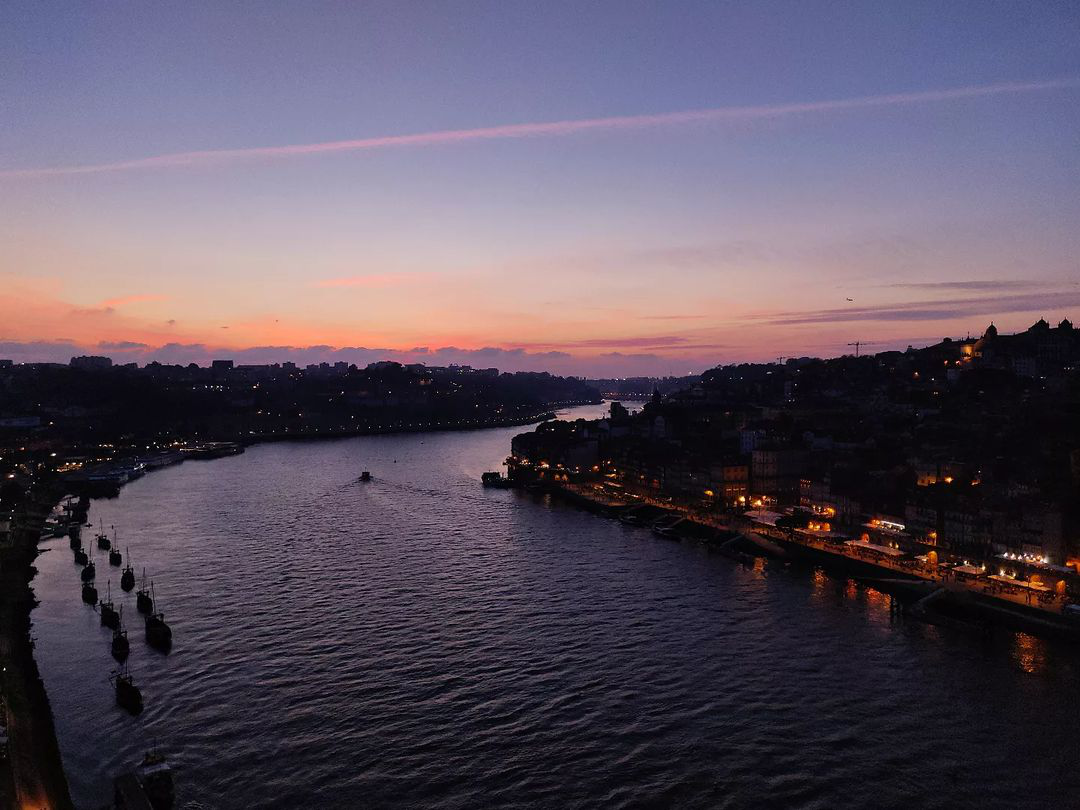

In [2]:
img = Image.open("image_samples/porto.jpg")
img

## Get RGB colors

In [3]:
# convert RGBA to RGB if necessary
n_dims = np.array(img).shape[-1]
n_dims # RGB -> has 3 channels

3

In [4]:
# Convert RGBA to RGB
if n_dims == 4:
    background = Image.new("RGB", img.size, (255, 255, 255))
    background.paste(img, mask=img.split()[3]) # 3 is the alpha channel
    img = background

In [5]:
r,g,b = np.array(img).reshape(-1,n_dims).T

## Store RGB colors of all pixels to DataFrame

In [6]:
df_rgb = pd.DataFrame({"R": r, "G": g, "B": b}).sample(n=1000)

In [7]:
df_rgb

R    G    B
704712   30   26   43
675058   75   71   88
394680  140  101  130
136996  115  116  160
841534   39   38   46
...     ...  ...  ...
831484    7    6   12
378973   74   26   12
797448   69   63   73
764882   31   27   41
158932  150  147  176

[1000 rows x 3 columns]

# Clustering

## Set Palette Size

Number of clusters is the palette size.

In [8]:
palette_size = 6

## Train KMeans Model

In [9]:
kmeans_model = KMeans(n_clusters=palette_size, 
                      random_state=0, 
                      init="k-means++",
                      n_init="auto").fit(df_rgb)

## Fetch Cluster Centers

The cluster centers are the palette colours in RGB Format

In [10]:
kmeans_model.cluster_centers_.astype(int).tolist()

[[16, 12, 19],
 [152, 140, 165],
 [209, 172, 165],
 [49, 41, 53],
 [111, 112, 154],
 [107, 89, 106]]

In [11]:
palette = kmeans_model.cluster_centers_.astype(int).tolist()

# Palette Visualization & Application

## Sort Palette

In [12]:
# palette.sort(key=lambda rgb: (lambda r, g, b : (r, g, b))(*rgb))
palette.sort(key=lambda rgb: (lambda r, g, b : colorsys.rgb_to_hsv(r, g, b))(*rgb))

In [13]:
palette

[[209, 172, 165],
 [111, 112, 154],
 [152, 140, 165],
 [16, 12, 19],
 [49, 41, 53],
 [107, 89, 106]]

## Visualize Palette

In [14]:
img_rgb = np.array([palette], dtype=np.uint8)
fig = px.imshow(img_rgb)
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.show()

## Use Palette in Seaborn

### Convert RGB to Hex Format

In [15]:
def rgb_to_hex(r, g, b):
    return '#{:02x}{:02x}{:02x}'.format(r, g, b)

In [16]:
list_hex = []

for each_rgb_col in palette:
    list_hex.append(rgb_to_hex(each_rgb_col[0], each_rgb_col[1], each_rgb_col[2]))
    
list_hex

['#d1aca5', '#6f709a', '#988ca5', '#100c13', '#312935', '#6b596a']

### Set the Palette

In [17]:
sns.set_palette(list_hex)

In [18]:
sns.color_palette()

[(0.8196078431372549, 0.6745098039215687, 0.6470588235294118),
 (0.43529411764705883, 0.4392156862745098, 0.6039215686274509),
 (0.596078431372549, 0.5490196078431373, 0.6470588235294118),
 (0.06274509803921569, 0.047058823529411764, 0.07450980392156863),
 (0.19215686274509805, 0.1607843137254902, 0.20784313725490197),
 (0.4196078431372549, 0.34901960784313724, 0.41568627450980394)]

### Example

In [19]:
a = list(range(0, 10))
b = np.random.rand(10)

<AxesSubplot:>

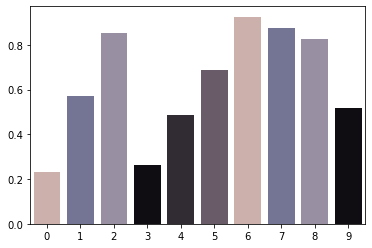

In [20]:
sns.barplot(x=a, 
            y=b,
            palette=sns.color_palette()
           )

## Use Palette in Plotly

In [21]:
import plotly.express as px
df = px.data.gapminder().query("year == 2007")
fig = px.bar(df, y="continent", x="pop", color="continent", orientation="h", hover_name="country",
             color_discrete_sequence=list_hex, # use the list of hex here
             title="Explicit color sequence"
            )

fig.show()

## Use Palette in Matplotlib

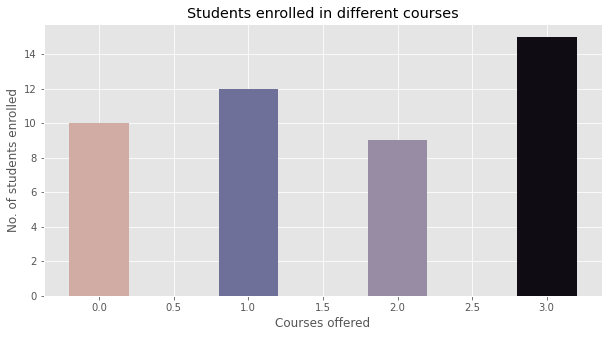

In [22]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar([0, 1, 2, 3], [10, 12, 9, 15], color = list_hex,
        width = 0.4)
 
plt.xlabel("Courses offered")
plt.ylabel("No. of students enrolled")
plt.title("Students enrolled in different courses")
plt.show()

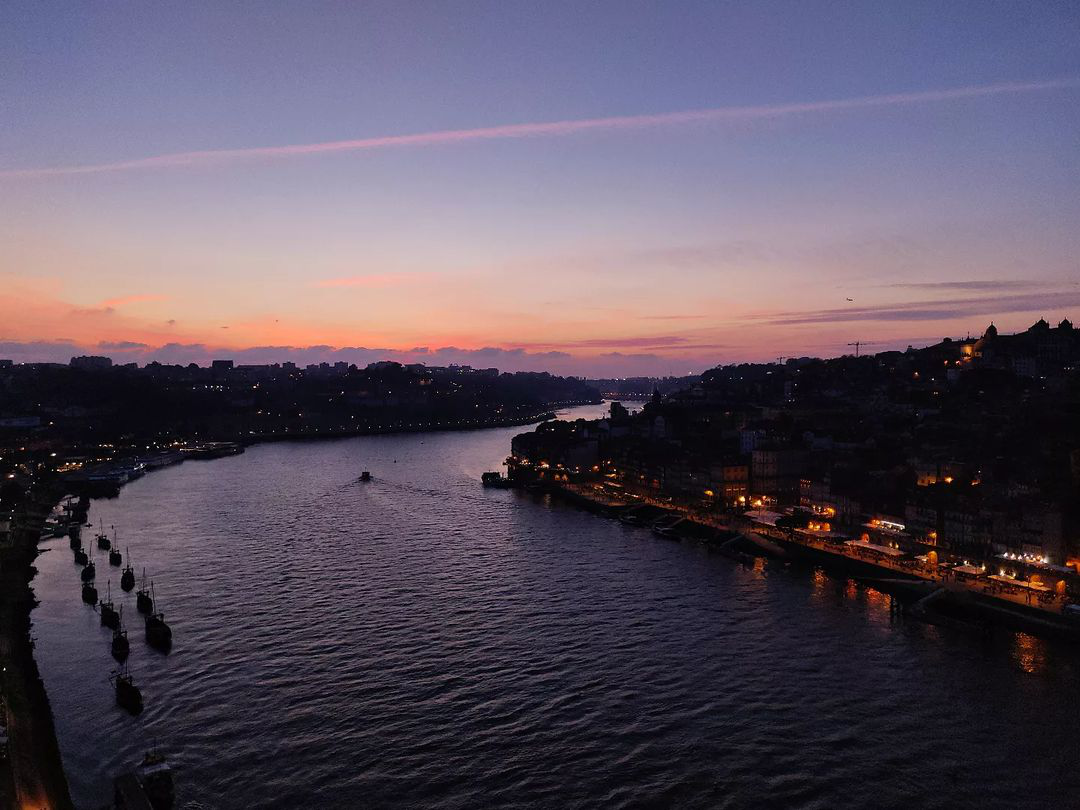

[(0.8196078431372549, 0.6745098039215687, 0.6470588235294118),
 (0.43529411764705883, 0.4392156862745098, 0.6039215686274509),
 (0.596078431372549, 0.5490196078431373, 0.6470588235294118),
 (0.06274509803921569, 0.047058823529411764, 0.07450980392156863),
 (0.19215686274509805, 0.1607843137254902, 0.20784313725490197),
 (0.4196078431372549, 0.34901960784313724, 0.41568627450980394)]

In [23]:
display(img)
sns.color_palette(list_hex)

# Cluster Analysis

In [24]:
clusters = kmeans_model.predict(df_rgb)
df_rgb['n_cluster'] = clusters

In [25]:
df_rgb[df_rgb['n_cluster'] == 0].head()

R   G   B  n_cluster
489036   9   7  10          0
814814  18  17  25          0
464861  15  14  28          0
534191   9   9  11          0
434961  12   9  18          0

In [26]:
df_rgb['hex_code'] = df_rgb.apply(lambda x: rgb_to_hex(x[0], x[1], x[2]), axis = 1)

In [27]:
for each_cluster in range(0, palette_size):
    print('Cluster ', each_cluster)
    display(sns.color_palette(list(df_rgb[df_rgb['n_cluster'] == each_cluster]['hex_code'][:10])))

Cluster  0


[(0.03529411764705882, 0.027450980392156862, 0.0392156862745098),
 (0.07058823529411765, 0.06666666666666667, 0.09803921568627451),
 (0.058823529411764705, 0.054901960784313725, 0.10980392156862745),
 (0.03529411764705882, 0.03529411764705882, 0.043137254901960784),
 (0.047058823529411764, 0.03529411764705882, 0.07058823529411765),
 (0.06274509803921569, 0.0392156862745098, 0.054901960784313725),
 (0.07058823529411765, 0.06666666666666667, 0.13725490196078433),
 (0.054901960784313725, 0.047058823529411764, 0.09803921568627451),
 (0.0392156862745098, 0.03529411764705882, 0.06666666666666667),
 (0.03529411764705882, 0.03137254901960784, 0.054901960784313725)]

Cluster  1


[(0.6392156862745098, 0.4627450980392157, 0.4823529411764706),
 (0.6823529411764706, 0.6078431372549019, 0.7176470588235294),
 (0.5254901960784314, 0.5254901960784314, 0.6745098039215687),
 (0.6196078431372549, 0.5764705882352941, 0.6941176470588235),
 (0.6666666666666666, 0.6352941176470588, 0.7254901960784313),
 (0.5568627450980392, 0.5568627450980392, 0.6980392156862745),
 (0.5294117647058824, 0.5019607843137255, 0.6666666666666666),
 (0.6196078431372549, 0.4588235294117647, 0.49019607843137253),
 (0.5294117647058824, 0.5294117647058824, 0.6784313725490196),
 (0.5529411764705883, 0.5372549019607843, 0.6745098039215687)]

Cluster  2


[(0.8274509803921568, 0.7490196078431373, 0.7450980392156863),
 (0.9568627450980393, 0.596078431372549, 0.5137254901960784),
 (0.8823529411764706, 0.6823529411764706, 0.615686274509804),
 (0.792156862745098, 0.6901960784313725, 0.6862745098039216),
 (0.8235294117647058, 0.7490196078431373, 0.7568627450980392),
 (0.803921568627451, 0.6, 0.5176470588235295),
 (0.8352941176470589, 0.7176470588235294, 0.7098039215686275),
 (0.7294117647058823, 0.6745098039215687, 0.7254901960784313),
 (0.7803921568627451, 0.6470588235294118, 0.6392156862745098),
 (0.8431372549019608, 0.7215686274509804, 0.7019607843137254)]

Cluster  3


[(0.11764705882352941, 0.10196078431372549, 0.16862745098039217),
 (0.15294117647058825, 0.14901960784313725, 0.1803921568627451),
 (0.13725490196078433, 0.12549019607843137, 0.19215686274509805),
 (0.17254901960784313, 0.1568627450980392, 0.24705882352941178),
 (0.2235294117647059, 0.2, 0.24705882352941178),
 (0.12941176470588237, 0.12941176470588237, 0.1607843137254902),
 (0.2901960784313726, 0.19607843137254902, 0.19607843137254902),
 (0.19607843137254902, 0.17647058823529413, 0.2549019607843137),
 (0.25882352941176473, 0.24705882352941178, 0.2901960784313726),
 (0.13725490196078433, 0.12941176470588237, 0.17254901960784313)]

Cluster  4


[(0.5490196078431373, 0.396078431372549, 0.5098039215686274),
 (0.45098039215686275, 0.4549019607843137, 0.6274509803921569),
 (0.4392156862745098, 0.43529411764705883, 0.592156862745098),
 (0.4823529411764706, 0.47843137254901963, 0.6352941176470588),
 (0.36470588235294116, 0.38823529411764707, 0.5764705882352941),
 (0.43137254901960786, 0.4549019607843137, 0.6431372549019608),
 (0.42745098039215684, 0.4392156862745098, 0.615686274509804),
 (0.4823529411764706, 0.49411764705882355, 0.6627450980392157),
 (0.49411764705882355, 0.5098039215686274, 0.6588235294117647),
 (0.45098039215686275, 0.4666666666666667, 0.6549019607843137)]

Cluster  5


[(0.29411764705882354, 0.2784313725490196, 0.34509803921568627),
 (0.3803921568627451, 0.3333333333333333, 0.4117647058823529),
 (0.3215686274509804, 0.2784313725490196, 0.34509803921568627),
 (0.396078431372549, 0.34901960784313724, 0.42745098039215684),
 (0.34901960784313724, 0.3058823529411765, 0.37254901960784315),
 (0.48627450980392156, 0.4196078431372549, 0.49019607843137253),
 (0.30196078431372547, 0.2784313725490196, 0.3333333333333333),
 (0.3411764705882353, 0.30980392156862746, 0.4),
 (0.37254901960784315, 0.33725490196078434, 0.4117647058823529),
 (0.4588235294117647, 0.396078431372549, 0.4470588235294118)]

# Demo

In [28]:
def generate_palette(img, palette_size):
    n_dims = np.array(img).shape[-1]
    # Convert RGBA to RGB
    if n_dims == 4:
        background = Image.new("RGB", img.size, (255, 255, 255))
        background.paste(img, mask=img.split()[3])  # 3 is the alpha channel
        img = background
    r, g, b = np.array(img).reshape(-1, n_dims).T
    df = pd.DataFrame({"R": r, "G": g, "B": b}).sample(n=1000)
    kmeans_model = KMeans(n_clusters=palette_size,
                          random_state=0,
                          init="k-means++",
                          n_init="auto").fit(df)
    palette = kmeans_model.cluster_centers_.astype(int).tolist()
    palette.sort(key=lambda rgb: (lambda r, g, b: colorsys.rgb_to_hsv(r, g, b))(*rgb))
    list_hex = []
    for each_rgb_col in palette:
        list_hex.append(rgb_to_hex(each_rgb_col[0], each_rgb_col[1], each_rgb_col[2]))
    sns.set_palette(list_hex)
    return sns.color_palette()

In [ ]:
img_link = input("Image Link:")

In [ ]:
response = requests.get(img_link)
img = Image.open(BytesIO(response.content))
img.resize((round(img.size[0]/3), round(img.size[1]/3))) # resizing to fit here

In [ ]:
generate_palette(img, 5)